<a href="https://colab.research.google.com/github/MLenthusiastic/Autoencoders/blob/master/Davis_simple_contrastive_loss_with_train_and__eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext tensorboard

In [0]:
import os
logs_base_dir = "runs"
os.makedirs(logs_base_dir, exist_ok=True)

In [0]:
!kill 5777

In [0]:
%tensorboard --logdir {logs_base_dir}

In [0]:
import shutil
shutil.make_archive('runs', 'zip', 'runs')

training started
Epoch :  1 Stage :  train Loss :  0.2607183829225876
Epoch :  1 Stage :  eval Loss :  0.07332958027043125
Epoch :  2 Stage :  train Loss :  0.059276997601544416
Epoch :  2 Stage :  eval Loss :  0.057454876601696014
Epoch :  3 Stage :  train Loss :  0.051773367863562375
Epoch :  3 Stage :  eval Loss :  0.057102604007179085
Epoch :  4 Stage :  train Loss :  0.04239523121052318
Epoch :  4 Stage :  eval Loss :  0.05426837261201757
Epoch :  5 Stage :  train Loss :  0.03386269969934667
Epoch :  5 Stage :  eval Loss :  0.04367753186009147
Epoch :  6 Stage :  train Loss :  0.027918340831443116
Epoch :  6 Stage :  eval Loss :  0.03958353363541943
Epoch :  7 Stage :  train Loss :  0.023830395247097368
Epoch :  7 Stage :  eval Loss :  0.029674876961066868
Epoch :  8 Stage :  train Loss :  0.0187325999589154
Epoch :  8 Stage :  eval Loss :  0.04791011057342544
Epoch :  9 Stage :  train Loss :  0.0169270273608466
Epoch :  9 Stage :  eval Loss :  0.02630318955264308
Epoch :  10 Stag

ValueError: ignored

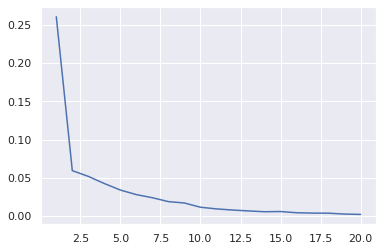

In [0]:
from torch.utils.data import Dataset
import json
import numpy as np
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
from google.colab.patches import cv2_imshow
from IPython.display import Image, display
import torch
import math
import torch.nn.functional as F
from argparse import ArgumentParser
import copy
import torch.nn.functional as F
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile


parser = ArgumentParser(description='Simple Contrastive Loss')
parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('--constractive_loss_margin', type=float, default=0.8)
parser.add_argument('--learning_rate', type=float, default=1e-4)
parser.add_argument('--num_epochs', type=int, default=100)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--device', type=str, default='cuda')
parser.add_argument('--validation_split', type=float, default=0.2)
parser.add_argument('--img_size', type=int, default=200)
parser.add_argument('--no_of_samples_per_class', type=int, default=100)
parser.add_argument('--no_of_classes', type=int, default=50)
parser.add_argument('--projector_img_size', type=int, default=32)

args, unknown = parser.parse_known_args()

DEVICE = args.device
if not torch.cuda.is_available():
    DEVICE = 'cpu'

class SimaseDavis(Dataset):

  def __init__(self, json_data, memmap):
      self.memmap = memmap
      self.json_data = json_data
      self.shape = self.json_data["shape"]
      self.objects = self.json_data["objects"]
      self.classes = self.json_data["classes"]

  def __getitem__(self, index):
    img_object_1 = self.objects[str(index)]
    img_object_1_width = img_object_1['width']
    img_object_1_height = img_object_1['height']
    image_1 =  self.memmap[index, :, :img_object_1_width, :img_object_1_height].astype(np.float32)
    class_1 = img_object_1['class']


    target = np.random.randint(0, 2)

    if target == 0:  #similar classes
        random_class_2 = np.random.choice(self.classes[class_1])
        random_class_2_idx = random_class_2["object_idx"]
        if index == random_class_2_idx: #given index and random selected indexes are same
           if len(self.classes[class_1]) != 1: #having only one object
            temp_classes = copy.deepcopy(self.classes[class_1])
            temp_classes.remove(random_class_2)
            random_class_2_rand = np.random.choice(temp_classes)
            random_class_2_idx = random_class_2_rand["object_idx"]
           else:
            random_class_2_idx = random_class_2["object_idx"]
        class_2 = class_1
        img_object_2 = self.objects[str(random_class_2_idx)]
        img_object_2_width = img_object_2['width']
        img_object_2_height = img_object_2['height']
        image_2 =  self.memmap[random_class_2_idx, :, :img_object_2_width, :img_object_2_height].astype(np.float32)

    else:
      all_class_labels = copy.deepcopy(list(self.classes.keys()))
      all_class_labels.remove(class_1)
      class_2 = np.random.choice(all_class_labels)
      img_object_2 = np.random.choice(self.classes[class_2])
      img_object_2_idx = img_object_2["object_idx"]
      img_object_2_width = img_object_2["width"]
      img_object_2_height = img_object_2["height"]
      image_2 =  self.memmap[img_object_2_idx, :, :img_object_2_width, :img_object_2_height].astype(np.float32)
    
    image_1_tensor_ext = torch.from_numpy(image_1).unsqueeze(dim=0)
    image_2_tensor_ext = torch.from_numpy(image_2).unsqueeze(dim=0)

    image_1_tensor = F.interpolate(image_1_tensor_ext, size=(args.img_size,args.img_size))
    image_2_tensor = F.interpolate(image_2_tensor_ext, size=(args.img_size,args.img_size))

    return image_1_tensor, image_2_tensor, target, class_1, class_2

  def __len__(self):
      return self.shape[0]

class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        #conv and fc works as encoder
        self.conv = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2)
                                  )
        
        # output 128, 21, 21 
        self.fc = nn.Sequential(nn.Linear(128 * 21 * 21, 1024),
                                nn.ReLU(),
                                nn.Linear(1024, 1024),
                                nn.ReLU(),
                                nn.Linear(1024, 128)
                                )
        
    def forward(self, in1, in2):
        x = torch.cat((in1, in2), dim=0)
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        z_out1, Z_out2 = torch.split(x, x.size(0) // 2, dim=0)
        return z_out1, Z_out2


class ContrastiveLoss(nn.Module):

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, target):
        eq_distance = F.pairwise_distance(output[0], output[1])
        loss = 0.5 * (1 - target) * torch.pow(eq_distance, 2) + \
               0.5 * target * torch.pow(torch.clamp(self.margin - eq_distance, min=0.00), 2)
        return loss.mean()
        
folder_path = './drive/My Drive/'
with open(folder_path+'train_davis.json') as json_file:
    train_davis_json = json.load(json_file)
with open(folder_path+'test_davis.json') as json_file:
    test_davis_json = json.load(json_file)

train_shape = train_davis_json["shape"]
train_memmap_path = folder_path+'train_davis.mmap'
train_davis_memmap = np.memmap(train_memmap_path, dtype='uint8', mode='r', shape=tuple(train_shape))

test_shape = test_davis_json["shape"]
test_memmap_path = folder_path+'test_davis.mmap'
test_davis_memmap = np.memmap(test_memmap_path, dtype='uint8', mode='r', shape=tuple(test_shape))

train_full_dataset = SimaseDavis(train_davis_json, train_davis_memmap)

split = int(np.floor(args.validation_split * len(train_full_dataset)))
indices = list(range(len(train_full_dataset)))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

davis_train_loader = torch.utils.data.DataLoader(train_full_dataset, batch_size=args.batch_size,
                                                   sampler=train_sampler,drop_last=True)
davis_val_loader = torch.utils.data.DataLoader(train_full_dataset, batch_size=args.batch_size,
                                                 sampler=valid_sampler, drop_last=True)

#train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = args.batch_size, shuffle=True)

tensorboard_writer = SummaryWriter()

model_save_path = './drive/My Drive/encoder_3.pth'


'''
#showing pairs
itf = next(iter(davis_dataloader))
img1, img2, target, class_1, class_2 = itf
img1 = img1.squeeze(dim=1)
img2 = img2.squeeze(dim=1)

for k in range(4):
  i = img1[k].numpy().transpose(2,1,0)
  cv2_imshow(i)
  j = img2[k].numpy().transpose(2,1,0)
  cv2_imshow(j)
'''


encoder = Encoder()
encoder = encoder.to(DEVICE)

criterion = ContrastiveLoss(margin=args.constractive_loss_margin)
optimizer = torch.optim.Adam(params=encoder.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

print('training started')

epoches = []
train_losses = []
eval_losses = []

def transform_image_for_projector(img_tensor):

  x_np = img_tensor.to('cpu').data.numpy()
  x_np = x_np.swapaxes(0, 1)
  x_np = x_np.swapaxes(1, 2)
  # H, W, C
  img = Image.fromarray(x_np.astype(np.uint8), mode='RGB')

  img = img.resize((args.projector_img_size, args.projector_img_size), Image.ANTIALIAS)
  img = np.array(img).astype(np.float)

  img = img.swapaxes(2, 1)
  img = img.swapaxes(1, 0)
  img /= 255
    
  return img

def draw_loss_plot(training_losses, validation_losses, epochs):
    plt.plot(epochs, training_losses, label="Train")
    plt.plot(epochs, validation_losses, label="eval")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

for epoch in range(1,args.num_epochs+1):

  epoches.append(epoch)
  train_batch_losses = []
  eval_batch_losses = []
  stage = ''

  for dataloader in [davis_train_loader,davis_val_loader]:

    if dataloader == davis_train_loader:
      encoder.train()
      torch.set_grad_enabled(True)
      stage = 'train'
    else:
      encoder.eval()
      torch.set_grad_enabled(False)
      stage = 'eval'
 
    for batch in dataloader:

        img_objects_1, img_objects_2, target , class_1, class_2 = batch
        
        img_objects_1_t = img_objects_1.squeeze(dim=1)
        img_objects_2_t = img_objects_2.squeeze(dim=1)
        img_obj_1 = img_objects_1_t.to(DEVICE)
        img_obj_2 = img_objects_2_t.to(DEVICE)
    
        z_out1, z_out2 = encoder(img_obj_1, img_obj_2)

        z_out = [z_out1, z_out2]

        target = target.to(DEVICE)

        loss = criterion(z_out, target)

        if dataloader == davis_train_loader:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_batch_losses.append(loss.item())
        else:
          eval_batch_losses.append(loss.item())

    if dataloader == davis_train_loader:    
      print('Epoch : ', epoch,'Stage : ', stage, 'Loss : ', np.mean(train_batch_losses))
      train_losses.append(np.mean(train_batch_losses))
      tensorboard_writer.add_scalar(scalar_value=np.mean(train_batch_losses), global_step=epoch, tag=f'{stage}_loss')
      torch.save(encoder.state_dict(), model_save_path)
    else:
      print('Epoch : ', epoch,'Stage : ', stage, 'Loss : ', np.mean(eval_batch_losses))
      eval_losses.append(np.mean(eval_batch_losses))
      tensorboard_writer.add_scalar(scalar_value=np.mean(train_batch_losses), global_step=epoch, tag=f'{stage}_loss')

  #adding to tensorboard projector

  encoder.eval()
  torch.set_grad_enabled(False)

  classes_dict = {}
  projector_labels = []
  projector_imgs = []
  projector_embeddings = []

  for dataloader in [davis_train_loader,davis_val_loader]:
    
    if dataloader == davis_train_loader:
       stage = 'train'
    else:
      stage = 'eval'
  
    for batch in dataloader:

      img_objects_1, img_objects_2, target , class_1, class_2 = batch

      img_objects_1_t = img_objects_1.squeeze(dim=1)
      img_objects_2_t = img_objects_2.squeeze(dim=1)
      img_obj_1 = img_objects_1_t.to(DEVICE)
      img_obj_2 = img_objects_2_t.to(DEVICE)

      z_out1, z_out2 = encoder(img_obj_1, img_obj_2)

      counter = 0
      for classes in [class_1, class_2]:
        if len(classes_dict.keys()) <= args.no_of_classes:
          for idx, single_class in enumerate(classes):
            counter += 1 
            if single_class not in classes_dict.keys():
              classes_dict[single_class] = 1
              projector_labels.append(single_class)
              if counter/args.batch_size == 0 :
                projector_imgs.append(transform_image_for_projector(img_objects_1_t[idx]))
                projector_embeddings.append(z_out1.cpu()[idx])
              else:
                projector_imgs.append(transform_image_for_projector(img_objects_2_t[idx]))
                projector_embeddings.append(z_out2.cpu()[idx])
            else:
              current_count = classes_dict.get(single_class)
              if current_count <= args.no_of_samples_per_class:
                  classes_dict[single_class] = current_count+1
                  projector_labels.append(single_class)
                  if counter/args.batch_size == 0 :
                    projector_imgs.append(transform_image_for_projector(img_objects_1_t[idx]))
                    projector_embeddings.append(z_out1.cpu()[idx])
                  else:
                    projector_imgs.append(transform_image_for_projector(img_objects_2_t[idx]))
                    projector_embeddings.append(z_out2.cpu()[idx])
  
    
    tensorboard_writer.add_embedding(
                    mat=torch.FloatTensor(np.stack(projector_embeddings)),
                    label_img=torch.FloatTensor(np.stack(projector_imgs)),
                    metadata=projector_labels,
                    global_step=epoch, tag=f'{stage}_emb_{epoch}')
  
  #tensorboard_writer.add_scalar(scalar_value=np.mean(batch_losses), global_step=epoch, tag=f'{stage}_loss' )
    
draw_loss_plot(train_losses, eval_losses, epoches)
